In [20]:
if False:
    import os
    import subprocess
    def execute_and_get_output(command):
        try:
            result = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
            print(result.decode('utf-8'))
        except subprocess.CalledProcessError as e:
            raise RuntimeError(
                "command '{}' return with error (code {}): {}".format(e.cmd, e.returncode, e.output.decode('utf-8')))
    def mount_and_pull(branch_name, drive, os):
        mgc = get_ipython().magic
        execute_and_get_output('git fetch')
        execute_and_get_output('git add -A')
        execute_and_get_output('git reset --hard')
        execute_and_get_output('git checkout {}'.format(branch_name))
        execute_and_get_output('git pull')
        execute_and_get_output('git branch')
        mgc('cd project_road_segmentation')
        execute_and_get_output('ls')
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/Shareddrives/ML_Road_Segmentation/CS-433-project-2'
    os.chdir(drive_path)
    BRANCH_NAME = 'ben-crap'
    mount_and_pull(BRANCH_NAME, drive, os)

In [11]:
import os
import sys
import gzip
import code
import urllib
import numpy as np
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
sys.path.append('./')
from helpers.helpers import *
from helpers.mask_to_submission import *

In [4]:
COLAB = False
RESTORE_MODEL = False  # If True, restore existing model instead of training a new one
GENERATE_PREDICTION = False #If True, will generate a CSV to submit on AICrowd

PREDICTIONS_SAVE_DIR = 'predictions/'
MODELS_SAVE_DIR = 'model_save/'
MODEL_NAME = 'new-u-net' #Chose between cnn_handmade and u-net

TRAINING_SAMPLES = 100 #max 100

TRAINING_SIZE = 80 # Size of the training set in percentage, integer between 0 and 100, the remaining part is for testing
VALIDATION_SIZE = 0.20  # Size of the validation set, float between 0 and 1
SEED = 66478  # Set to None for random seed.
NUM_EPOCHS = 8

NUM_CHANNELS = 3  # RGB images
PIXEL_DEPTH = 255
NUM_LABELS = 2
BATCH_SIZE = 16  # 64
RECORDING_STEP = 0

# Set image patch size in pixels
# IMG_PATCH_SIZE should be a multiple of 4
# image size should be an integer multiple of this number!
IMG_PATCH_SIZE = 16
IMAGE_SIZE = 400
if IMAGE_SIZE % IMG_PATCH_SIZE != 0 :
    print('Warning : the image size is not a multiple of the patch size')

In [5]:
from models.cnn_tf import *
from models.unet_tf import *
from models.other_unet_tf import *

models_dict = {
    'cnn_handmade' : {
        'name' : 'cnn',
        'model' : CNN,
        'save_dir' : MODELS_SAVE_DIR + 'cnn_handmade/'
    },
    'u-net' : {
        'name' : 'u-net',
        'model' : UNet,
        'save_dir' : MODELS_SAVE_DIR + 'u-net/'
    },
    'new-u-net' : {
        'name' : 'new-u-net',
        'model' : get_unet,
        'save_dir' : MODELS_SAVE_DIR + 'new-u-net/'
    },
}

model_chosen = models_dict[MODEL_NAME]

In [9]:
data_dir = 'data/training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 

def read_images(filename, num_images):
    imgs = []
    for i in tqdm(range(1, num_images+1)):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print('File ' + image_filename + ' does not exist')
    print('Loaded {} images'.format(len(imgs)))
    return np.asarray(imgs)

def convert_3c(groundtruths):
    def img_1c_to_3c(gt_img):
        w = gt_img.shape[0]
        h = gt_img.shape[1]
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        return gt_img_3c
    gt_3c = list(map(img_1c_to_3c, groundtruths))
    return np.asarray(gt_3c)

images = read_images(train_data_filename, TRAINING_SAMPLES)
groundtruths = read_images(train_labels_filename, TRAINING_SAMPLES) #1 channel groundtruths
masks = convert_3c(groundtruths) # 3 channels groundtruths

100%|██████████| 100/100 [00:02<00:00, 45.98it/s]


Loaded 100 images


100%|██████████| 100/100 [00:00<00:00, 348.63it/s]


Loaded 100 images


In [13]:
# we create two instances with the same arguments
data_gen_args = dict(rotation_range=90.,
                     horizontal_flip=True,
                     vertical_flip=True,
                     validation_split=VALIDATION_SIZE)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(images, augment=True, seed=SEED)
mask_datagen.fit(masks, augment=True, seed=SEED)

image_generator = image_datagen.flow(images, batch_size=32, seed=SEED) #batchsize of 32
mask_generator = mask_datagen.flow(masks, batch_size=32, seed=SEED)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


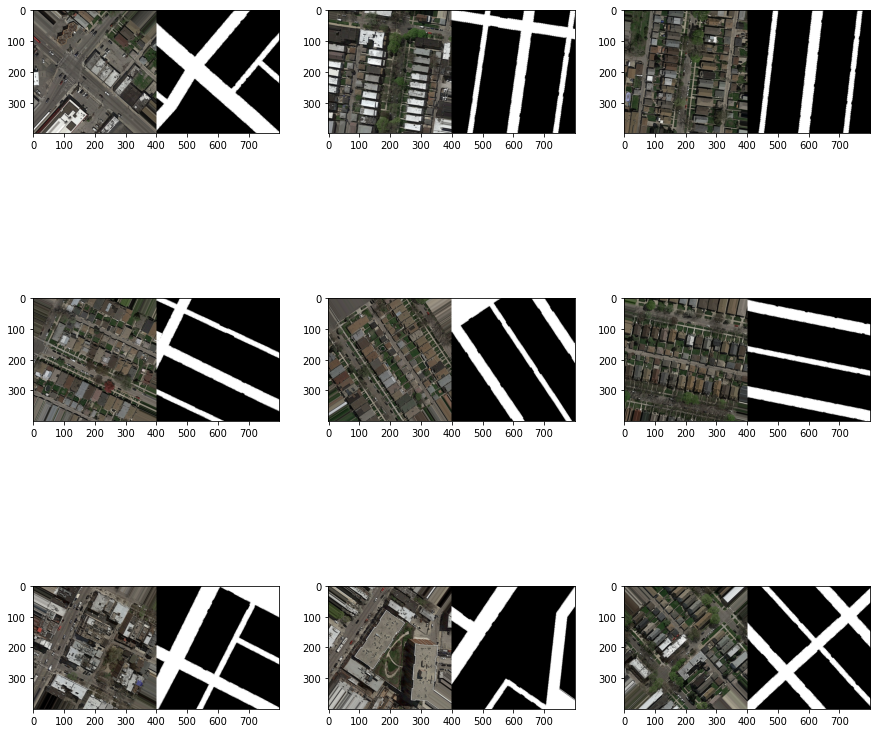

In [14]:
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    fig, axes=plt.subplots(3,3, figsize=(15,15))
    for i in range(0, 9):
        img = concatenate_images(X_batch[i], y_batch[i])
        axes[i//3, i%3].imshow(img)
    # show the plot
    plt.show()
    break

In [23]:
X_train, X_test, y_train, y_test = train_test_split(images, groundtruths,\
                                                    train_size= TRAINING_SIZE/100, random_state=SEED)

In [24]:
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.keras import layers, models

#This cell is required for me (Ben), otherwise I get "convolution algorithm not found"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Set to true")
    print(physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Set to true
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    """Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    """
   
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean(numerator / (denominator + epsilon)) # average over classes and batch

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

from keras import backend as K

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coeff(y_true, y_pred)

  metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]

if RESTORE_MODEL:
    # It can be used to reconstruct the model identically.
    model = models.load_model(model_chosen['save_dir'])
else:  
    model = model_chosen['model']()
    
    model.compile(optimizer='adam',
            loss="binary_crossentropy",
            metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs = NUM_EPOCHS ,validation_split=VALIDATION_SIZE)

In [ ]:
if not RESTORE_MODEL:
    model.save(model_chosen['save_dir'])

In [ ]:
with tf.device('/cpu:0'):
    pred_train_original = model.predict(X_train).squeeze()

In [ ]:
pred_train = pred_train_original.copy()
print(pred_train[0].max(),' prediction ', pred_train[0].min())
print(y_train[0].max(),' label (groundtruth) ', y_train[0].min())
print(X_train[0].max(),' training image ', X_train[0].min())

THRESHOLD = ((pred_train.max() + pred_train.min()) / 2)
pred_train[pred_train >= THRESHOLD] = 1.0
pred_train[pred_train < THRESHOLD] = 0.0
pred_train = (pred_train -1)*-1 #Inverting the labels to match the images
print(pred_train[0])
for i in np.random.randint(int(TRAINING_SAMPLES*TRAINING_SIZE/100), size=4):
    plt.figure()
    img1 = concatenate_images(X_train[i], pred_train_original[i])
    img2 = concatenate_images(img1, pred_train[i])
    img3 = concatenate_images(img2, y_train[i])
    plt.imshow(img3)

In [ ]:
if COLAB:
    from helpers.colab import download_model
    from google.colab import files
    download_model(MODEL_NAME, model_chosen['save_dir'], files)